In [348]:
## import modules

import numpy as np
from numpy import random
import os
from tqdm import tqdm
import pandas as pd
from imageio import imread
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.color import rgb2gray

plt.style.use('ggplot')

In [393]:
train_path = 'stage1_train/'
test_path = 'stage1_test/'

train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

seed = 42
random.seed = seed
np.random.seed = seed

In [350]:
imgs = []
img_data = []
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path + id_
    img = imread(path + '/images/' + id_ + '.png')
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    img_area = img_width * img_height
    
    mask_count = 0
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_count = mask_count + 1
    
    imgs.append(img)
    img_data.append([id_, img_height, img_width, img_area, mask_count])


100%|██████████| 670/670 [00:09<00:00, 71.50it/s]


In [351]:
df_imgs = pd.DataFrame(img_data, columns=['ID', 'height', 'width', 'area', 'n_mask'])
df_imgs.head()

,ID,height,width,area,n_mask
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,256,256,65536,27
1,003cee89357d9fe13516167fd67b609a164651b2193458...,256,256,65536,36
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,256,320,81920,70
3,0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...,256,320,81920,86
4,01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...,256,320,81920,7


Different area:[  65536   81920  129600   90220  361920 1048576  327680  767016 1443520]


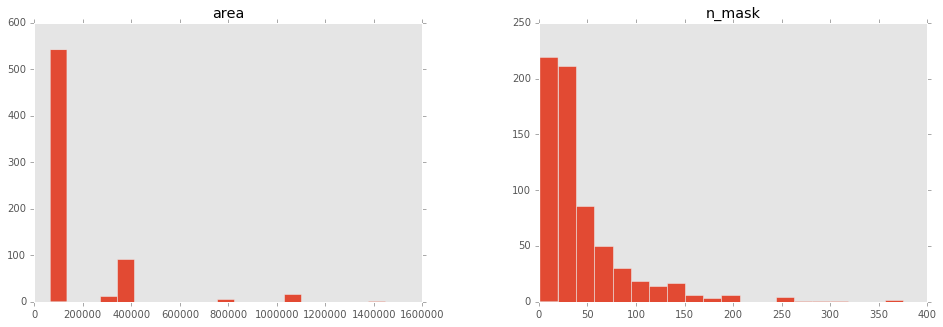

In [353]:
df_imgs[['area', 'n_mask']].hist(figsize=(16,5), bins=20)
print("Different area:{}".format(df_imgs['area'].unique()))
#print(df_imgs['n_mask'].unique())

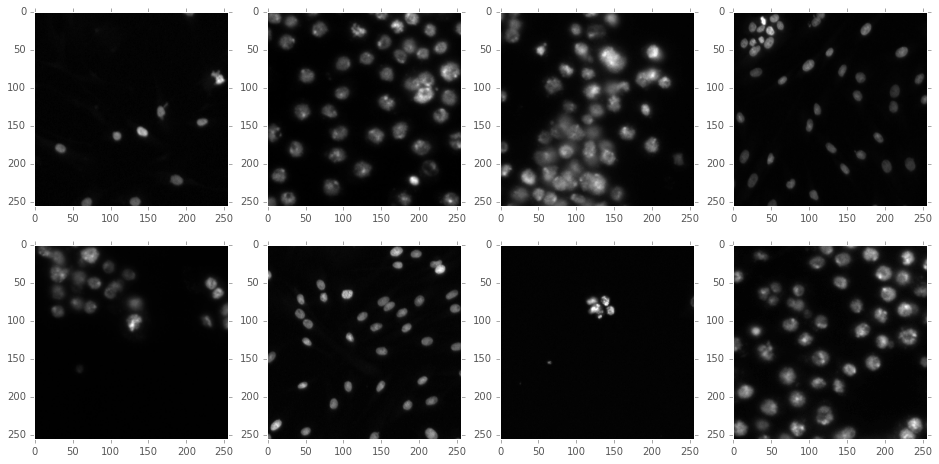

In [356]:
## Show the 256*256 images
n_area = df_imgs['area'].unique()
gd_area = df_imgs.groupby('area').get_group(n_area[0])
samples = gd_area.sample(8, random_state=seed).index

fig = plt.figure(figsize=(16,16))
plt.rcParams['grid.linewidth'] = 0.0
for i, item in enumerate(samples):
    plt.subplot(4, 4, i+1)
    img = imgs[item]
#    plt.imshow(img, cmap='gray')
    plt.imshow(rgb2gray(img), cmap='gray')

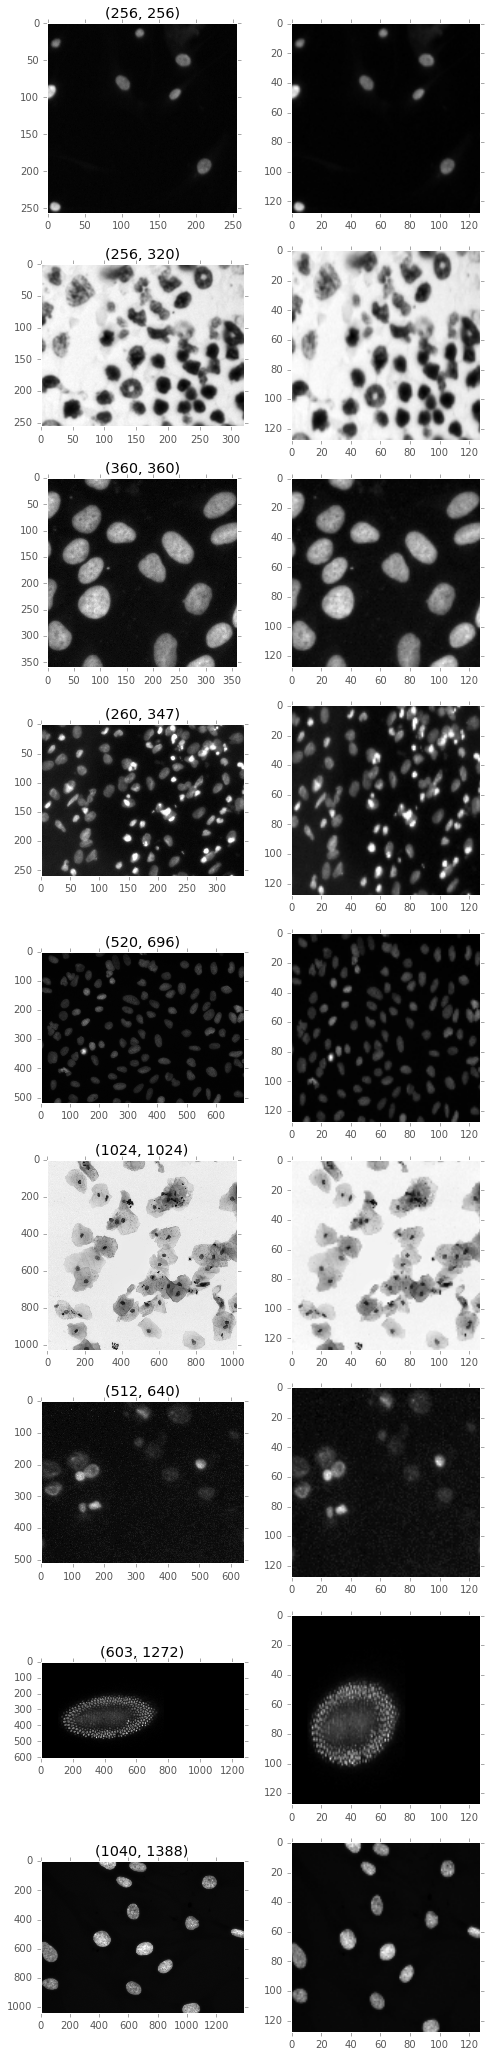

In [367]:
## Randomly plot figures from each size and resize them to 128*128

img_width = 128
img_height = 128
img_channels = 3
fig = plt.figure(figsize=(8,36))
for i in range(len(n_area)):
    gd_area = df_imgs.groupby('area').get_group(n_area[i])
    sample = gd_area.sample(1, random_state=seed, replace=True).index[0]
    plt.subplot(9, 2, 2*i+1)
    img = imgs[sample]
    plt.imshow(rgb2gray(img), cmap='gray')
    plt.title(rgb2gray(img).shape)
    plt.subplot(9, 2, 2*i+2)
    img_resize = resize(img, (img_width, img_height), preserve_range=True, mode='constant')
    plt.imshow(rgb2gray(img_resize), cmap='gray')

In [398]:
### Resize images

print('Getting and resizing training data ... ')
X_train = np.zeros((len(train_ids), img_height, img_width))
Y_train = np.zeros((len(train_ids), img_height, img_width, 1), dtype=np.bool)
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]
    img = rgb2gray(img)
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X_train[n] = img
    
    mask = np.zeros((img_height, img_width, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask


print('Getting and resizing test data ... ')
X_test = np.zeros((len(test_ids), img_height, img_width))
sizes_test = []
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = rgb2gray(img)
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X_test[n] = img
    

  0%|          | 0/670 [00:00<?, ?it/s]

Getting and resizing training data ... 


  9%|▉         | 6/65 [00:00<00:01, 53.32it/s]

Getting and resizing test data ... 


100%|██████████| 65/65 [00:01<00:00, 39.33it/s]


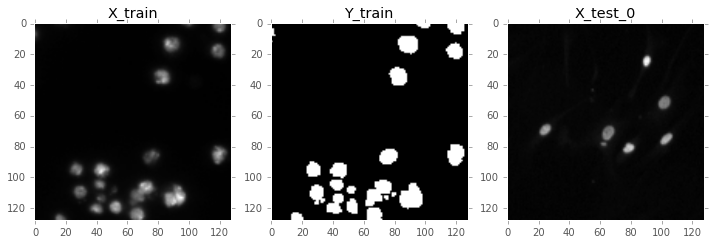

In [401]:
## show images again
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(X_train[0], cmap="gray")
plt.title("X_train")
plt.subplot(132)
plt.imshow(np.squeeze(Y_train[0]), cmap="gray")
plt.title("Y_train")
plt.subplot(133)
plt.imshow(X_test[0], cmap="gray")
plt.title("X_test_0")
plt.show()

In [411]:
## save data
train_set = np.stack((np.expand_dims(X_train, axis=-1), Y_train), axis=1)
print(train_set.shape)
test_set = np.expand_dims(X_test, axis=-1)
print(test_set.shape)

np.savetxt()

(670, 2, 128, 128, 1)
(65, 128, 128, 1)


In [56]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 22 separate components / objects detected.


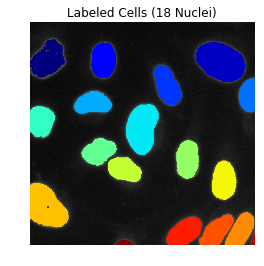

In [53]:
# Create a random colormap
from matplotlib.colors import ListedColormap
#rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display)#, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()


In [38]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # Check if the label size is too small
    if np.product(cell.shape) < 10: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

# Regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

There are now 18 separate components / objects detected.


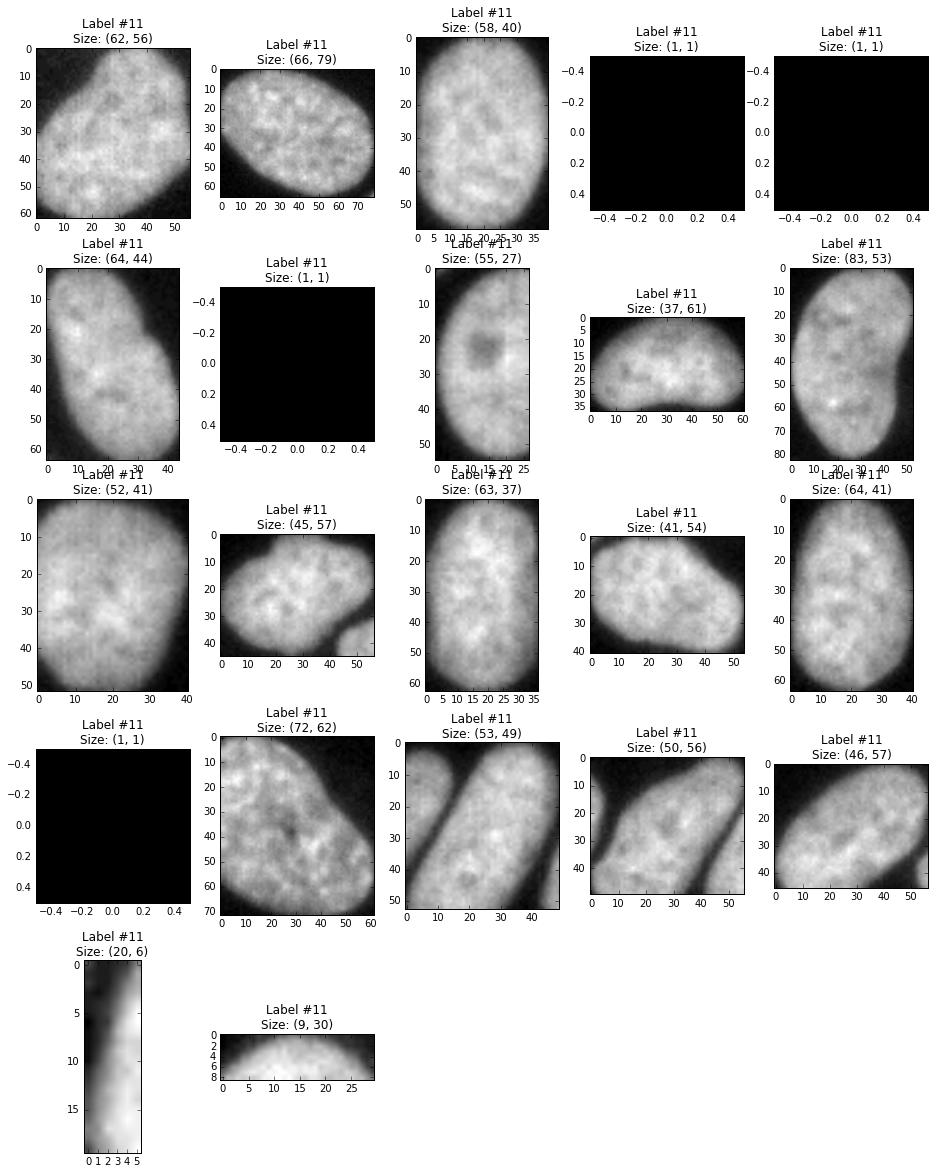

In [57]:
def show_labels(data):
    n = len(data)
    columns = 5
    fig = plt.figure(figsize=(16,4*(n//columns+1)))
    for i, obj_indices in enumerate(data):
        plt.subplot(n//columns+1, columns, i+1)
        cell = im_gray[obj_indices]
        plt.imshow(cell, cmap='gray')
        plt.title('Label #{}\nSize: {}'.format(ii+1, cell.shape))
    plt.show()

data = ndimage.find_objects(labels)
show_labels(data)

In [58]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 49320 1 49679 2 50038 3 50398 3 50756 5 51116 5 51475 6 51835 6 52194 7 52554 7 52913 8 53273 8 53633 8 53992 9 54352 9 54713 8 55073 8 55433 8 55793 8 56153 8 56514 7 56874 7 57234 7 57595 6 57956 5 58316 5 58677 4 59038 3 59399 2 59760 1


In [66]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = (128, 128, 3)

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

128


In [119]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for n, id_ in enumerate(train_ids[:1]):#, total=len(train_ids[:10]):
    path = TRAIN_PATH + id_
    img = imageio.imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    i = 0
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imageio.imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        i += 1 
        print(mask_.shape, i)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask
##    print(Y_train[:1].shape)

((128, 128, 1), 1)
((128, 128, 1), 2)
((128, 128, 1), 3)
((128, 128, 1), 4)
((128, 128, 1), 5)
((128, 128, 1), 6)
((128, 128, 1), 7)
((128, 128, 1), 8)
((128, 128, 1), 9)
((128, 128, 1), 10)
((128, 128, 1), 11)
((128, 128, 1), 12)
((128, 128, 1), 13)
((128, 128, 1), 14)
((128, 128, 1), 15)
((128, 128, 1), 16)
((128, 128, 1), 17)
((128, 128, 1), 18)
((128, 128, 1), 19)
((128, 128, 1), 20)
((128, 128, 1), 21)
((128, 128, 1), 22)
((128, 128, 1), 23)
((128, 128, 1), 24)
((128, 128, 1), 25)
((128, 128, 1), 26)
((128, 128, 1), 27)


(670, 128, 128, 3)
